<!-- <img  src="https://swan.web.cern.ch/sites/swan.web.cern.ch/files/pictures/logo_swan_letters.png" alt="SWAN" style="float: left; width: 15%; margin-right: 5%; margin-left: 17%; margin-top: 1.0em; margin-bottom: 2.0em;">
<img src="https://spark.apache.org/images/spark-logo-trademark.png" alt="EP-SFT" style="float: left; width: 25%; margin-right: 0%; margin-left: 0%; margin-bottom: 2.0em;">
<img src="https://cms-docdb.cern.ch/cgi-bin/PublicDocDB/RetrieveFile?docid=3045&filename=CMSlogo_color_label_1024_May2014.png&version=3" alt="CMS" style="float: left; width: 12%; margin-left: 5%; margin-right: 5%; margin-bottom: 2.0em;"> -->
<p style="clear: both;">
<div style="text-align:center"><h1>CMS H&#8594;µµ analysis with Apache Spark  
     <br> using Coffea and Laurelin packages from Fermilab</h1></div>
<div style="text-align:center"><i>Author: Dmitry Kondratyev, based on example code by Lindsey Gray</i></div>
<hr style="border-top-width: 4px; border-top-color: #34609b;">

# Search for Higgs boson decaying into two muons

This code uses awkward array toolset, and utilizing Coffea [histograms](https://coffeateam.github.io/coffea/modules/coffea.hist.html).
This also shows the analysis object syntax implemented by Coffea [JaggedCandidateArray](https://coffeateam.github.io/coffea/api/coffea.analysis_objects.JaggedCandidateMethods.html), and the usage of custom [accumulators](https://coffeateam.github.io/coffea/api/coffea.processor.AccumulatorABC.html) other than histograms.  Further, it introduces the [processor](https://coffeateam.github.io/coffea/api/coffea.processor.ProcessorABC.html) concept and the interface to apache spark.

#### SWAN env: LCG96 Python3 stack and Cloud Containers cluster

In [ ]:
# Run this cell if you do not have coffea installed (e.g. on SWAN with LCG 96Python3 stack)
!pip install --user --upgrade coffea

# spark.jars.packages doesnt work with Spark 2.4 with kubernetes
!wget -N https://repo1.maven.org/maven2/edu/vanderbilt/accre/laurelin/0.5.1/laurelin-0.5.1.jar && \
wget -N https://repo1.maven.org/maven2/org/apache/logging/log4j/log4j-api/2.11.2/log4j-api-2.11.2.jar && \
wget -N https://repo1.maven.org/maven2/org/apache/logging/log4j/log4j-core/2.11.2/log4j-core-2.11.2.jar && \
wget -N https://repo1.maven.org/maven2/org/lz4/lz4-java/1.5.1/lz4-java-1.5.1.jar && \
wget -N https://repo1.maven.org/maven2/org/tukaani/xz/1.2/xz-1.2.jar

In [1]:
# Run this cell before establishing spark connection

import os
os.environ['PYTHONPATH'] = os.environ['PYTHONPATH'] + ':' + '/usr/local/lib/python3.6/site-packages'

In [2]:
import time
import coffea
print(coffea.__version__)

from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor

0.6.27


In [3]:
# Look at ProcessorABC documentation to see the expected methods and what they are supposed to do
# https://coffeateam.github.io/coffea/api/coffea.processor.ProcessorABC.html
class DimuonProcessor(processor.ProcessorABC):
    def __init__(self):
        self._columns = ['nMuon', 'Muon_pt', 'Muon_eta', 'Muon_phi', 'Muon_mass', 'Muon_charge',
                         'nJet', 'Jet_pt', 'Jet_eta', 'Jet_phi', 'Jet_mass',
                        'PV_npvsGood', 'genWeight']
        dataset_axis = hist.Cat("dataset", "")

        axes = {}
        axes['dimuon_mass'] =  hist.Bin("dimuon_mass", r"$m_{\mu\mu}$ [GeV]", 100, 76, 106)
        axes['dimuon_pt'] = hist.Bin("dimuon_pt", r"$p_{T}(\mu\mu)$ [GeV]", 100, 0, 400)
        axes['mu1_pt'] = hist.Bin("mu1_pt", r"$p_{T}(\mu_{1})$ [GeV]", 100, 0, 400)
        axes['mu2_pt'] = hist.Bin("mu2_pt", r"$p_{T}(\mu_{2})$ [GeV]", 100, 0, 300)
        axes['jet_pt'] = hist.Bin("jet_pt", r"$p_{T}(jet)$ [GeV]", 100, 0, 400)
        axes['njets'] = hist.Bin("njets", "njets", 10, 0, 10)
        axes['npv'] = hist.Bin("npv", "npv", 50, 0, 50)
        axes['genweight'] = hist.Bin("genweight", "genweight", 50, 0, 50)
        # TODO: reimplement genweight (weighting should be done before filling histograms)
        
        variables = axes.keys()
        
        accumulators = {}
        for v in variables:
            accumulators[v] = hist.Hist("Counts", dataset_axis, axes[v])
            
        accumulators['sumGenWeights'] = hist.Hist("sumGenWeights", dataset_axis)
        accumulators['entries'] = hist.Hist("Entries", dataset_axis)
        accumulators['cutflow'] = processor.defaultdict_accumulator(int)
        
        self._accumulator = processor.dict_accumulator(accumulators)
    
    @property
    def accumulator(self):
        return self._accumulator
    
    @property
    def columns(self):
        return self._columns
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
        # Select and fill general event info
        # >> HLT bits, electron veto
        if 'data' not in dataset:
            genweight = df['genWeight']
            output['sumGenWeights'].fill(dataset=dataset, weight=genweight)
        
        # Select and fill muons and dimuon pair
        
        muons = JaggedCandidateArray.candidatesfromcounts(
            df['nMuon'],
            pt=df['Muon_pt'].content,
            eta=df['Muon_eta'].content,
            phi=df['Muon_phi'].content,
            mass=df['Muon_mass'].content,
            charge=df['Muon_charge'].content,
            )
        
        # TODO: Add FSR recovery here

        # TODO: Add muon scale factors
        
        output['cutflow']['all events'] += muons.size
           
        #print(muons['__fast_pt'].shape) # yields number of events
        #print(muons.pt.shape) # yields number of events
        #print(muons.pt.content.shape) # yields number of muons
        
        #print(f"nEvts: {muons.shape}") # yields number of events
        #print(muons.content.shape) # yields number of muons
        
        muons = muons[muons.pt > 20]
        event_filter = ((muons.counts == 2) & (muons['charge'].prod() == -1)).flatten()
        # event_filter has dimensionality = nEvts
        
        muons = muons[event_filter]
        
        # TODO: Add Rochester correction
            
        dimuons = muons.distincts()
        
        
        leading_muons = dimuons['0']
        subleading_muons = dimuons['1']
        
        #TODO: check if this implementation from Coffea example is better
#         leading_mu = (dimuons.i0.pt.content > dimuons.i1.pt.content)
#         pt_lead = JaggedArray.fromoffsets(dimuons.offsets, np.where(leading_mu,
#                                                                     dimuons.i0.pt.content, dimuons.i1.pt.content))
#         pt_trail = JaggedArray.fromoffsets(dimuons.offsets, np.where(~leading_mu,
#                                                                      dimuons.i0.pt.content, dimuons.i1.pt.content))

        
        dimuon_filter = ((leading_muons['__fast_pt'] > 26) & (dimuons.mass > 76) & (dimuons.mass < 106)).flatten()
        # dimuon_filter has dimensionality = events passing event_filter
        
        dimuons = dimuons[dimuon_filter]
        muons = muons[dimuon_filter]
        
        output['cutflow']['event_filter'] += event_filter.sum()
        output['cutflow']['dimuon_filter'] += dimuon_filter.sum()

        
        output['dimuon_mass'].fill(dataset=dataset, dimuon_mass=dimuons.mass.flatten())        
        output['dimuon_pt'].fill(dataset=dataset, dimuon_pt=dimuons.pt.flatten())
        output['mu1_pt'].fill(dataset=dataset, mu1_pt=leading_muons['__fast_pt'].flatten())
        output['mu2_pt'].fill(dataset=dataset, mu2_pt=subleading_muons['__fast_pt'].flatten())
        output['entries'].fill(dataset=dataset, weight=muons.size) # temporary
        # TODO: dimuon_eta, dimuon_phi, dimuon_deta, dimuon_dphi, dimuon_costhetaCS, dimuon_phiCS,
        #       eta, phi of mu1 and mu2
        
        # Select and fill jets and jet pairs
        # TODO: njets, nsoftjets, jet pT, eta, phi, QGL; dijet mass, eta, phi, deta, dphi
        
        jets = JaggedCandidateArray.candidatesfromcounts(
            df['nJet'],
            pt=df['Jet_pt'].content,
            eta=df['Jet_eta'].content,
            phi=df['Jet_phi'].content,
            mass=df['Jet_mass'].content,
            )
        
        jets = jets[jets.pt > 20]
        jets = jets[event_filter]
        jets = jets[dimuon_filter]

        output['jet_pt'].fill(dataset=dataset, jet_pt=jets.pt.flatten())
        output['njets'].fill(dataset=dataset, njets=jets.counts)
        
        # Fill kinematic variables of multimuon-multijet system
        # >> many of them...
        
        # Fill other variables
        # TODO: number of vertices, MET
        npv = df['PV_npvsGood']
        npv = npv[event_filter]
        output['npv'].fill(dataset=dataset, npv=npv)
        
        # TODO: Add initial categorization (ggH vs. VBF)
        
        # Fill event weights
        # TODO: PU weight, NNLOPS reweighting, Zpt reweighting
        
        # TODO: Add systematic uncertainties
        
        # TODO: Evaluate DNN
        
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [3]:
# To implement nanoEvents
class DimuonProcessorNano(processor.ProcessorABC):
    def __init__(self):
    
    @property
    def accumulator(self):
        return self._accumulator
    
    @property
    def columns(self):
        return self._columns
    
    def process(self, df):
        output = self.accumulator.identity()
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [4]:
import glob

paths = {
'data': ['/eos/cms/store/data/Run2016C/SingleMuon/NANOAOD/Nano25Oct2019-v1/40000/',], # can add more
'dy': '/eos/cms/store/mc/RunIISummer16NanoAODv6/DYJetsToLL_M-50_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/NANOAODSIM/PUMoriond17_Nano25Oct2019_102X_mcRun2_asymptotic_v7_ext2-v1/100000/',
'ttjets_dl': '/eos/cms/store/mc/RunIISummer16NanoAODv6/TTJets_DiLept_TuneCUETP8M1_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUMoriond17_Nano25Oct2019_102X_mcRun2_asymptotic_v7-v1/270000/'
}

# TODO: add remote loading of files
# TODO: add Golden JSON lumi-section filter

samples = paths.keys()

fileset = {}
fileset_lite = {}
for sample, path in paths.items():
    all_files = []
    if isinstance(path, list): # possibility to load files from multiple local paths
        for p in path:
            all_files += glob.glob(p+'*root')
    else:                      # ... or just one local path
        all_files = glob.glob(path+'*root')
    
    print(f"{sample}: {len(all_files)} files")
    
    fileset[sample] = {
        'files': ['root://eoscms.cern.ch/'+f for f in all_files],
        'treename': 'Events'
    }

    fileset_lite[sample] = {
        'files': ['root://eoscms.cern.ch/'+all_files[0]], # for debugging, use only one file from each sample
        'treename': 'Events'
    }
    

data: 28 files
dy: 58 files
ttjets_dl: 6 files


In [ ]:
# DEBUG: iterative processing 
# skip this cell if running Spark
# skip next cell if debugging

if True:
    from coffea.processor.executor import iterative_executor
    output = processor.run_uproot_job(fileset_lite, 'Events', DimuonProcessor(), iterative_executor, executor_args={'nano': False})
    print(output)

NOW IT IS TIME TO START SPARK CLUSTER CONNECTION

When using SWAN, click on the 5-point start icon in Jupyter notebook

In [5]:
import pyspark.sql
from pyarrow.compat import guid
from coffea.processor.spark.detail import _spark_initialize, _spark_stop
from coffea.processor.spark.spark_executor import spark_executor
"""
# NOT needed on SWAN, spark config is offloaded to spark connector

spark_config = pyspark.sql.SparkSession.builder \
    .appName('spark-executor-test-%s' % guid()) \
    .master('local[*]') \
    .config('spark.driver.memory', '4g') \
    .config('spark.executor.memory', '4g') \
    .config('spark.sql.execution.arrow.enabled','true') \
    .config('spark.sql.execution.arrow.maxRecordsPerBatch', 200000)

spark = _spark_initialize(config=spark, log_level='WARN', 
                          spark_progress=False, laurelin_version='0.5.1')
"""
partitionsize = 200000
thread_workers = 2

tstart = time.time() 

output = processor.run_spark_job(fileset_lite, DimuonProcessor(), spark_executor, 
                                 spark=spark, partitionsize=partitionsize, thread_workers=thread_workers,
                                 executor_args={'file_type': 'edu.vanderbilt.accre.laurelin.Root', 'cache': False, 'nano': False}
                                )

elapsed = time.time() - tstart
print(output)
print("Total time: ", elapsed)
print("Events/s:", output['cutflow']['all events']/elapsed)

/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/pyarrow/__init__.py:152: UserWarning: pyarrow.open_stream is deprecated, please use pyarrow.ipc.open_stream
  warnings.warn("pyarrow.open_stream is deprecated, please use "



{'dimuon_mass': <Hist (dataset,dimuon_mass) instance at 0x7f07a5ce6898>, 'dimuon_pt': <Hist (dataset,dimuon_pt) instance at 0x7f07714c6be0>, 'mu1_pt': <Hist (dataset,mu1_pt) instance at 0x7f07714c6cf8>, 'mu2_pt': <Hist (dataset,mu2_pt) instance at 0x7f07714c6c18>, 'jet_pt': <Hist (dataset,jet_pt) instance at 0x7f07714c6cc0>, 'njets': <Hist (dataset,njets) instance at 0x7f07714db438>, 'npv': <Hist (dataset,npv) instance at 0x7f07714dbb00>, 'genweight': <Hist (dataset,genweight) instance at 0x7f07714db518>, 'sumGenWeights': <Hist (dataset) instance at 0x7f07714dbc88>, 'entries': <Hist (dataset) instance at 0x7f07714dbcc0>, 'cutflow': defaultdict(<class 'int'>, {'all events': 7528015, 'event_filter': 564744, 'dimuon_filter': 401194})}
Total time:  131.46053647994995
Events/s: 57264.44757927908


In [6]:

def plot_variable(var, gs, weights):
    
    new_output = output[var].copy() # copy to prevent scaling multiple times
    new_output.scale(weights, axis='dataset')
    
    
    # Group the samples for plotting (will be important when we unite low-yield samples like V)
    
    data = new_output['data']
    
    bkg_sources = {
        'dy': ['dy'],
        'ttbar':['ttjets_dl'],  
    }
    bkg = new_output.group('dataset', hist.Cat("dataset", "Dataset"), bkg_sources)
    bkg.axis('dataset').sorting = 'integral' # sort backgrounds by event yields
    
    data_opts = {'color': 'k', 'marker': '.', 'markersize':15}
    stack_fill_opts = {'alpha': 0.8, 'edgecolor':(0,0,0)}
    stack_error_opts = {'label':'Stat. unc.','facecolor':(0,0,0,.4), 'hatch':'', 'linewidth': 0}
    
    # Top panel: Data vs. MC plot
    plt1 = fig.add_subplot(gs[0])
    ax_bkg = hist.plot1d(bkg, ax=plt1, overlay='dataset', overflow='all', stack=True, fill_opts=stack_fill_opts, error_opts=stack_error_opts)
    ax_data = hist.plot1d(data, overlay='dataset', overflow='all', line_opts=None, error_opts=data_opts)
    plt1.set_yscale('log')
    plt1.set_ylim(0.1, 1e7)
    lbl = hep.cms.cmslabel(plt1, data=True, paper=False, year='2016')
    plt1.set_xlabel('')
    plt1.tick_params(axis='x', labelbottom=False)
    

    # Bottom panel: Data/MC ratio plot
    # TODO: add MC uncertainty (shaded)
    plt2 = fig.add_subplot(gs[1], sharex=plt1)
    num = data.sum('dataset')
    denom = bkg.sum('dataset')
    hist.plotratio(num=num, ax=plt2,
                    denom=denom,
                    error_opts=data_opts, denom_fill_opts={}, guide_opts={},
                    unc='num')
    
    
    plt2.axhline(1, ls='--')
    plt2.set_ylim([0,2])    
    plt2.set_ylabel('Data/MC')


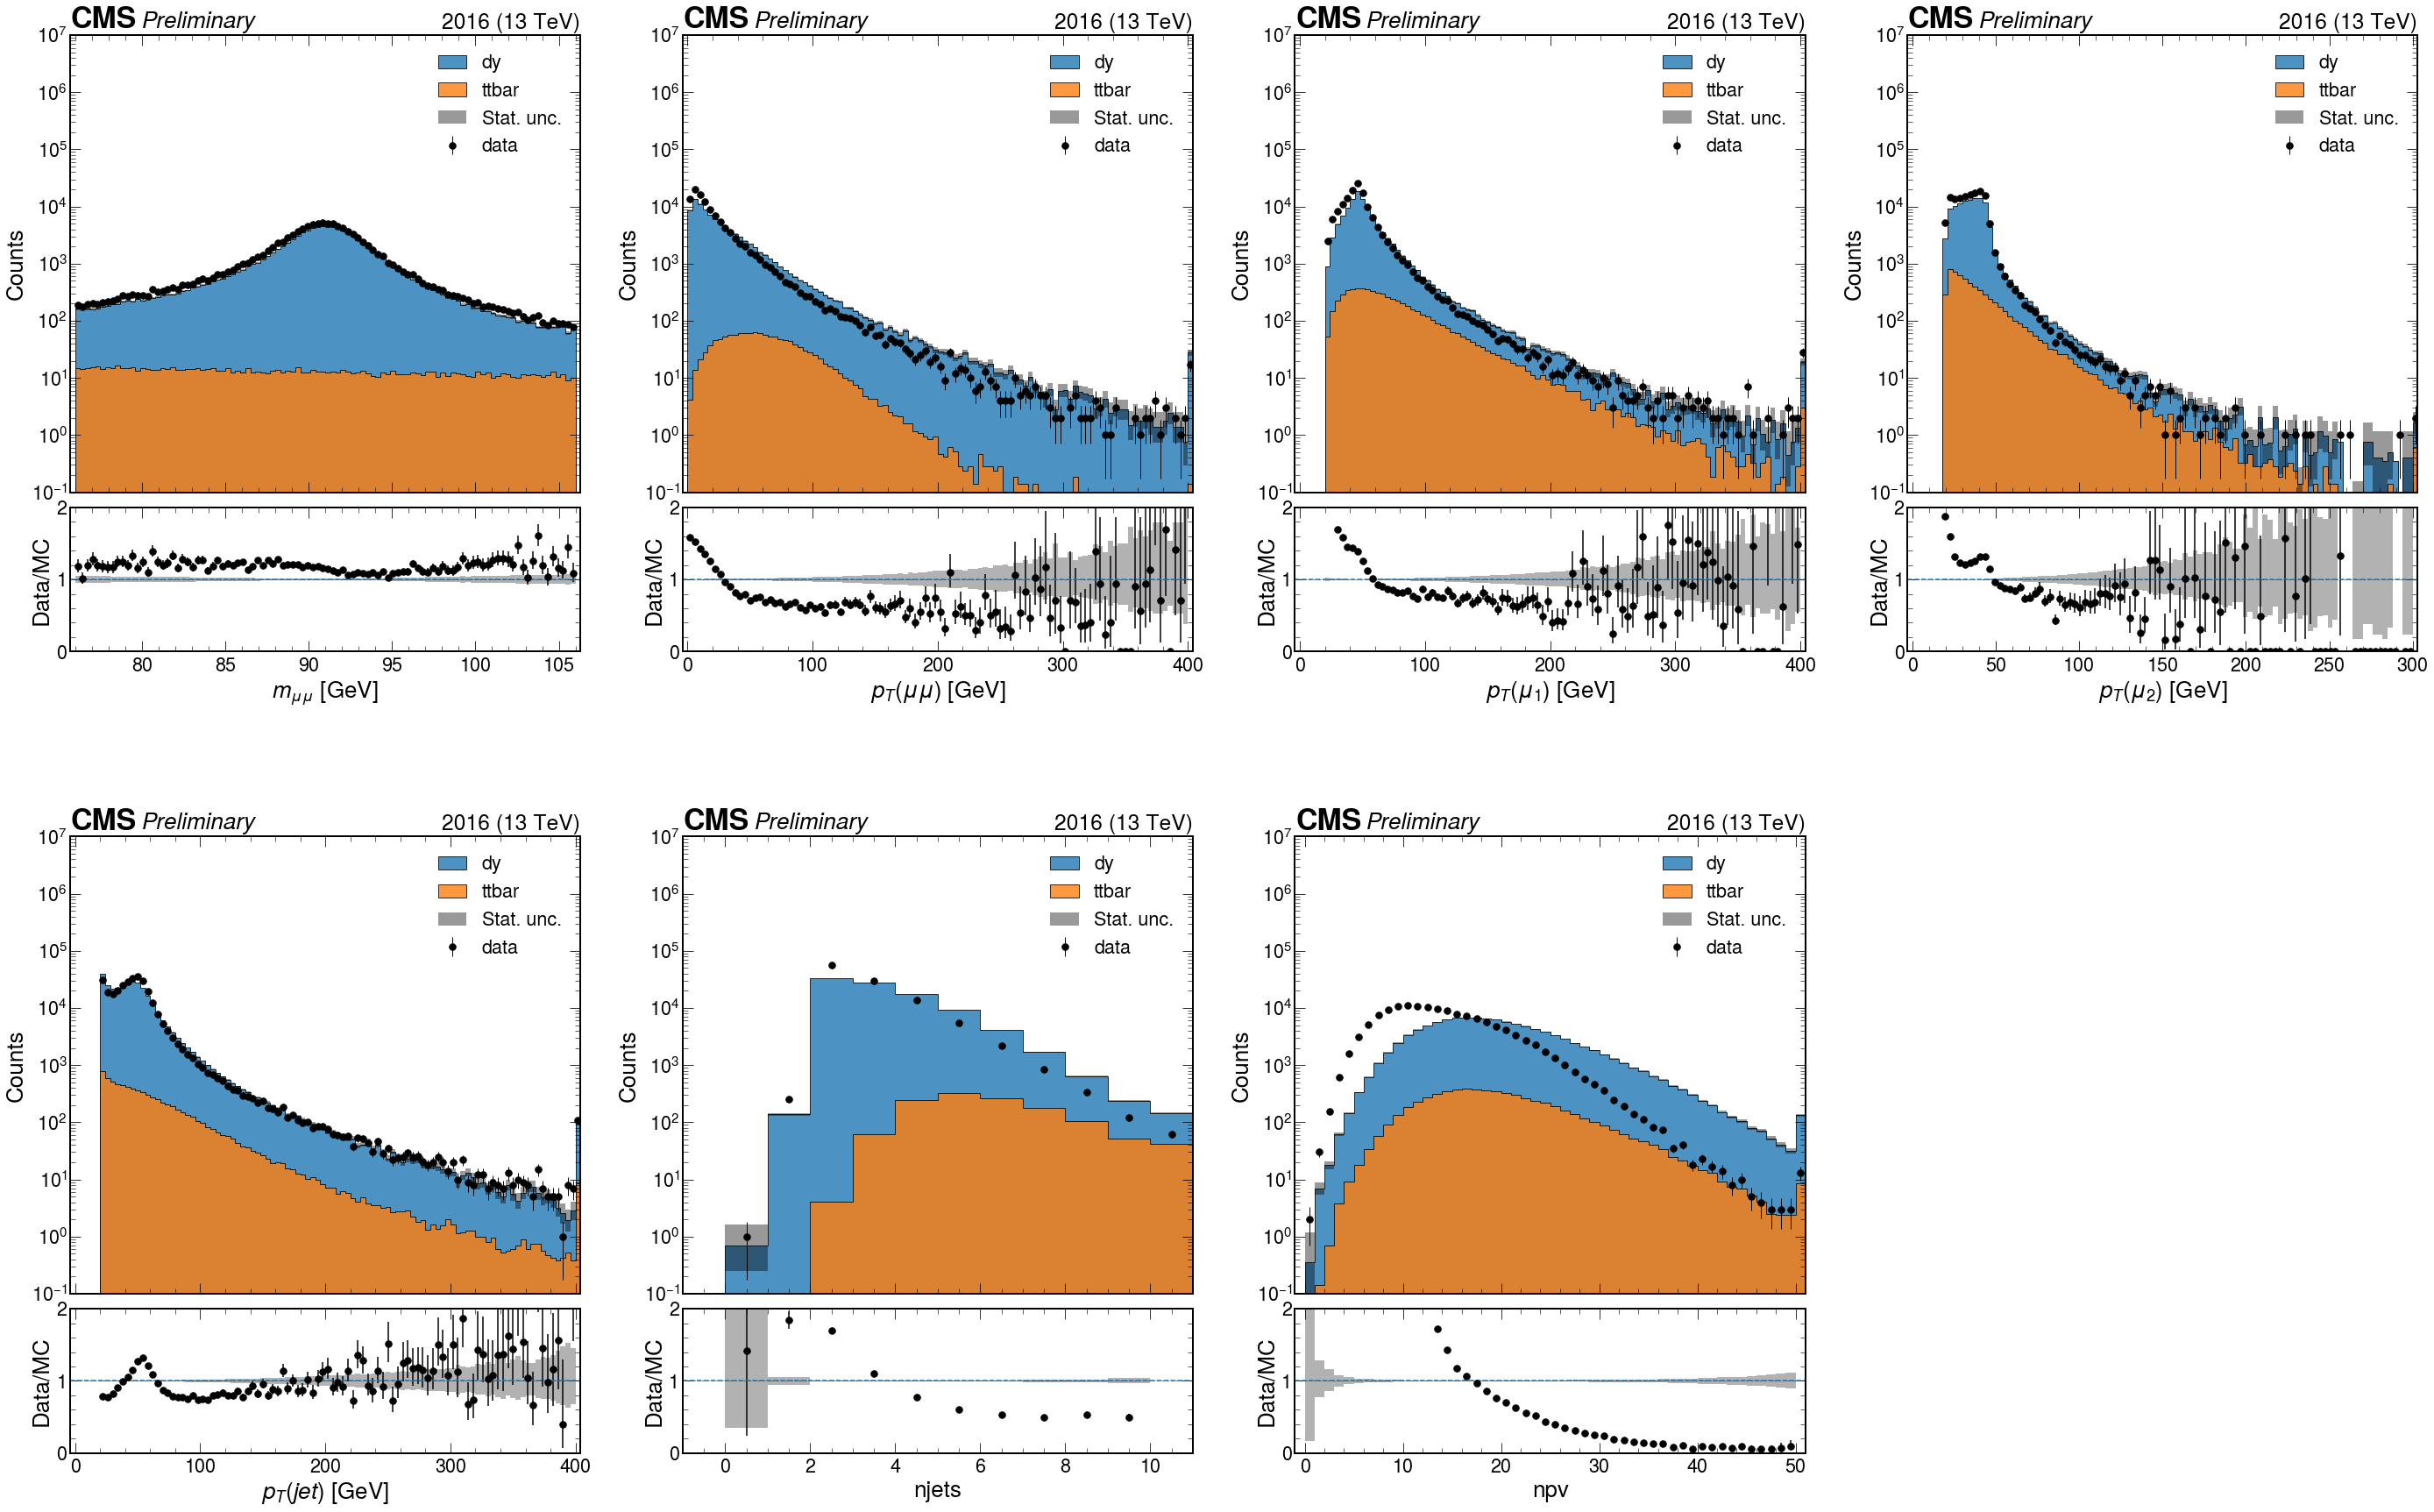

In [12]:
%matplotlib inline
#%matplotlib notebook # interactive mode
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.cms.style.ROOT)
from matplotlib import gridspec
import math
import numpy as np
from parameters import cross_sections

mc_datasets = [s for s in samples if 'data' not in s]

# Luminosity weight (maybe should be done in postprocess()?)
lumi_weights = {'data':1}
lumi = 15
# TODO: add proper luminosity evaluation

# print(output['sumGenWeights'].values())
# print(output['entries'].values())

for mc in mc_datasets:
    N = output['entries'].values().get((mc,)).sum() # temporary - will replace with sum of weights
    lumi_weights[mc] = cross_sections[mc]*lumi / N

    
# Plotting
vars_to_plot = ['dimuon_mass', 'dimuon_pt','mu1_pt','mu2_pt', 'jet_pt', 'njets', 'npv']
nplots_x = 4 # number of plots in one row
nplots_y = math.ceil(len(vars_to_plot) / nplots_x) # number of rows

fig = plt.figure()
plotsize=12
ratio_plot_size = 0.24
fig.set_size_inches(nplots_x*plotsize,nplots_y*plotsize*(1+ratio_plot_size))

outer_grid = gridspec.GridSpec(nplots_y, nplots_x, hspace = .3) 

# TODO: parallelize
for i, var in enumerate(vars_to_plot):
    gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = outer_grid[i], height_ratios=[(1-ratio_plot_size),ratio_plot_size], hspace = .05)
    plot_variable(var, gs, lumi_weights)
